In [1]:
!pip install torchmetrics
!pip install torchinfo

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import ToTensor, Resize
import torch.nn as N
import matplotlib.pyplot as plt
import cv2 as cv2
import itertools

In [3]:
torch.manual_seed(42)

batch_size = 32
epochs = 5
learning_rate = 1e-3

filters = [32, 64, 128, 256]
drop_rate= 0.15

num_classes = 3

In [4]:
transforms = [Resize((256,256))]

In [5]:
OxfordIIITPet('../pytorch-basics/datasets', 'trainval', 'segmentation', download= True)

100%|██████████| 791918971/791918971 [00:31<00:00, 25077125.90it/s]


Extracting ../pytorch-basics/datasets/oxford-iiit-pet/images.tar.gz to ../pytorch-basics/datasets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10660616.08it/s]


Extracting ../pytorch-basics/datasets/oxford-iiit-pet/annotations.tar.gz to ../pytorch-basics/datasets/oxford-iiit-pet


Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ../pytorch-basics/datasets

In [6]:
class OxfordPetDataset(Dataset):
    def __init__(self, split= 'trainval', transforms= []) -> None:
        self.transforms = transforms

        self.list_of_files = []
        self.input_dir = '../pytorch-basics/datasets/oxford-iiit-pet/images/'
        self.target_dir = '../pytorch-basics/datasets/oxford-iiit-pet/annotations/trimaps/'

        if(split == 'trainval'):
            file_list_path = '../pytorch-basics/datasets/oxford-iiit-pet/annotations/trainval.txt'
        else:
            file_list_path = '../pytorch-basics/datasets/oxford-iiit-pet/annotations/test.txt'

        with open(file_list_path, 'r') as f:
            for line in f.readlines():
                self.list_of_files.append(line.split(' ')[0])

    def __len__(self):
        return(len(self.list_of_files))

    def __getitem__(self, index):
        input_path = self.input_dir + self.list_of_files[index] + '.jpg'
        target_path = self.target_dir + self.list_of_files[index] + '.png'

        input = ToTensor()(cv2.imread(input_path))
        target = torch.IntTensor(cv2.imread(target_path, flags= cv2.IMREAD_UNCHANGED))

        if len(target.shape) == 2:
            target = target[None, :, :]

        for transform in self.transforms:
            input = transform(input)
            target = transform(target)

        return (input, target)

In [7]:
training_data = OxfordPetDataset('trainval', transforms= transforms)
test_data = OxfordPetDataset('test', transforms= transforms)

In [8]:
train_dataloader = DataLoader(training_data, batch_size= batch_size, shuffle= True, drop_last= True)
test_dataloader = DataLoader(test_data, batch_size= batch_size, shuffle= True, drop_last= True)

In [9]:
sample_index =  torch.randint(0, len(test_dataloader), size= (1,))
sample_input, sample_target = next(itertools.islice(test_dataloader, sample_index, None))

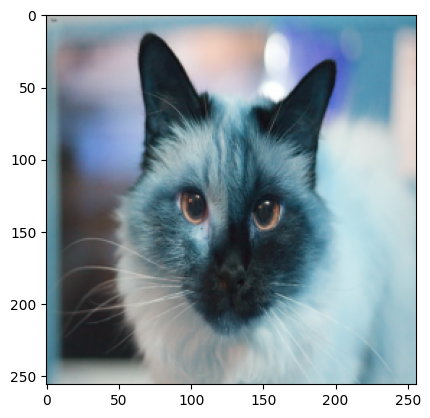

In [10]:
plt.imshow(sample_input[0].permute(1,2,0))

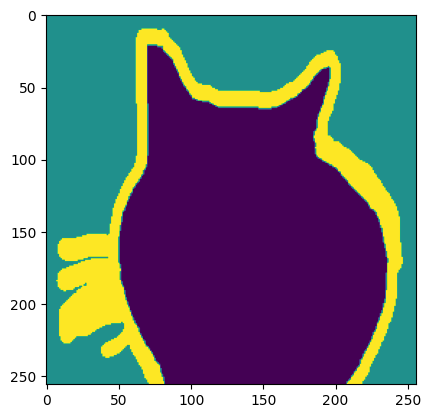

In [11]:
plt.imshow(sample_target[0].permute(1,2,0))

In [12]:
class DownwardBlock(N.Module):
    def __init__(self, in_channels, out_channels, device, stride= 1, kernel_size= 3, padding= 'same'):
        super(DownwardBlock, self).__init__()

        self.enc_block = N.Sequential(
            N.Conv2d(in_channels, out_channels, kernel_size, stride, padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True),

            N.Conv2d(out_channels, out_channels, kernel_size, stride, padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True)
        )

    def forward(self, input):
        output = self.enc_block(input)
        return output

In [13]:
class DownwardHalf(N.Module):
    def __init__(self, filters, device):
        super(DownwardHalf, self).__init__()
        self.down_blocks = N.ModuleList()
        self.mpool = N.MaxPool2d(kernel_size= 2, stride= 2)

        for i in range(len(filters)):
            if i == 0:
                self.down_blocks.append(DownwardBlock(3, filters[i], device= device))
            else:
                self.down_blocks.append(DownwardBlock(filters[i-1], filters[i], device= device))

    def forward(self, input):
        skip_conn = []
        for i in range(len(self.down_blocks)):
            input = self.down_blocks[i](input)
            skip_conn.append(input)
            input = self.mpool(input)

        return input, skip_conn

In [14]:
class UpwardBlock(N.Module):
    def __init__(self, in_channels, out_channels, device, stride= 1, kernel_size= 3, padding='same'):
        super(UpwardBlock, self).__init__()

        self.tconv = N.ConvTranspose2d(in_channels, out_channels, kernel_size= 2, stride= 2, device= device)
        self.dec_block = N.Sequential(
            N.Conv2d(in_channels, out_channels, kernel_size, stride, padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True),

            N.Conv2d(out_channels, out_channels, kernel_size, stride, padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True)
        )

    def forward(self, input, skip_conn):
        tconv_output = self.tconv(input)
        concat_output = torch.cat([tconv_output, skip_conn], dim= 1)
        output = self.dec_block(concat_output)

        return output

In [15]:
class UpwardHalf(N.Module):
    def __init__(self, filters, device):
        super(UpwardHalf, self).__init__()
        self.up_blocks = N.ModuleList()
        n = len(filters)

        for i in range(n):
          self.up_blocks.append(UpwardBlock(filters[n-i-1] * 2, filters[n-i-1], device))

    def forward(self, input, skip_conn):
        n = len(self.up_blocks)
        for i in range(n):
            input = self.up_blocks[i](input, skip_conn[n-i-1])

        return input

In [16]:
class UNet(N.Module):
    def __init__(self, filters, device):
        super(UNet, self).__init__()
        self.down_half = DownwardHalf(filters, device)
        self.up_half = UpwardHalf(filters, device)
        self.final_conv = N.Conv2d(filters[0], num_classes, 3, 1, 'same', device= device)
        self.bridge_block = N.Sequential(
            N.Conv2d(filters[-1], filters[-1] * 2, 3, 1, 'same', device= device, bias= False),
            N.BatchNorm2d(filters[-1] * 2, device= device),
            N.ReLU(inplace= True),

            N.Conv2d(filters[-1] * 2, filters[-1] * 2, 3, 1, 'same', device= device, bias= False),
            N.BatchNorm2d(filters[-1] * 2, device= device),
            N.ReLU(inplace= True)
        )

    def forward(self, input):
        down_half_output, skip_conn = self.down_half(input)
        bridge_block_output = self.bridge_block(down_half_output)
        up_half_output = self.up_half(bridge_block_output, skip_conn)
        output = self.final_conv(up_half_output)

        return output

In [17]:
from torchinfo import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(filters, device)

summary(model, input_size= (batch_size, 3, 256, 256), col_names=['input_size', 'output_size', 'num_params', 'trainable'],

        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                       Input Shape               Output Shape              Param #                   Trainable
UNet (UNet)                                   [32, 3, 256, 256]         [32, 3, 256, 256]         --                        True
├─DownwardHalf (down_half)                    [32, 3, 256, 256]         [32, 256, 16, 16]         --                        True
│    └─ModuleList (down_blocks)               --                        --                        (recursive)               True
│    │    └─DownwardBlock (0)                 [32, 3, 256, 256]         [32, 32, 256, 256]        10,208                    True
│    └─MaxPool2d (mpool)                      [32, 32, 256, 256]        [32, 32, 128, 128]        --                        --
│    └─ModuleList (down_blocks)               --                        --                        (recursive)               True
│    │    └─DownwardBlock (1)                 [32, 32, 128, 128]        [32, 64, 128, 128]    

In [18]:
from torchmetrics.segmentation import MeanIoU, GeneralizedDiceScore

loss_fn = N.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
IoU = MeanIoU(3)
DiceScore = GeneralizedDiceScore(3)

In [ ]:
for _ in range(epochs):
    train_loss = 0
    print(f"\nStarting epoch {_ + 1}\n~~~~~~~~~~~~~~")

    for index, (input, target) in enumerate(train_dataloader):
        input, target = input.cuda(), target.cuda()
        model.train()
        output = model(input)

        target -= 1
        target = target.type(torch.int64)
        target = N.functional.one_hot(target, num_classes)
        target = target.squeeze().type(torch.float32).permute(0,3,1,2)

        loss = loss_fn(output, target)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(index % 100 == 0):
            print(f"Batch: {index} Loss:{loss:0.9f}")

        train_loss /= len(train_dataloader)
    test_loss, test_dice = 0, 0
    model.eval()

    with torch.inference_mode():
        for test_input, test_target in test_dataloader:
            test_input, test_target = test_input.cuda(), test_target.cuda()

            test_target -= 1
            test_target = test_target.type(torch.int64)
            test_target = N.functional.one_hot(test_target, num_classes)
            test_target = test_target.squeeze().type(torch.float32).permute(0,3,1,2)

            test_pred = model(test_input)
            test_loss += loss_fn(test_pred, test_target)
            # test_dice += DiceScore(test_target, test_pred)

        test_loss /= len(test_dataloader)
        test_dice /= len(test_dataloader)

    print(f"Train loss: {train_loss:0.5f} Test loss: {test_loss:0.5f} Test dice score: {test_dice:0.2f}")


Starting epoch 1
~~~~~~~~~~~~~~
Batch: 0 Loss:1.144879460
Batch: 100 Loss:0.605006456
Train loss: 0.00472 Test loss: 0.69885 Test dice score: 0.00

Starting epoch 2
~~~~~~~~~~~~~~
Batch: 0 Loss:0.604834437
Batch: 100 Loss:0.624454975
